In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from torchtext.legacy.data import Field, BucketIterator, TabularDataset

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

import spacy
import numpy as np
from tqdm.notebook import tqdm

import random
import math
import time

In [2]:
SEED = 1234

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [3]:
spacy_ru = spacy.load('ru_core_news_sm')
spacy_en = spacy.load('en_core_web_sm')

def tokenize_ru(text):
    """
    Tokenizes Russian text from a string into a list of strings
    """
    return [tok.text for tok in spacy_ru.tokenizer(text)]

def tokenize_en(text):
    """
    Tokenizes English text from a string into a list of strings
    """
    return [tok.text for tok in spacy_en.tokenizer(text)]

In [4]:
SRC = Field(tokenize = tokenize_en, 
            init_token = '<sos>', 
            eos_token = '<eos>', 
            lower = True, 
            include_lengths = False,
            batch_first=True)

TRG = Field(tokenize = tokenize_ru, 
            init_token = '<sos>', 
            eos_token = '<eos>', 
            lower = True,
            batch_first=True)

In [5]:
path_to_data = "../data.txt"

In [6]:
dataset = TabularDataset(
    path=path_to_data,
    format='tsv',
    fields=[('src', SRC), ('trg', TRG)]
)

In [7]:
train_data, valid_data, test_data = dataset.split(split_ratio=[0.8, 0.15, 0.05])

In [8]:
SRC.build_vocab(train_data, min_freq = 2)
TRG.build_vocab(train_data, min_freq = 2)

In [9]:
BATCH_SIZE = 16

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

train_iterator, valid_iterator, test_iterator = BucketIterator.splits(
    (train_data, valid_data, test_data), 
     batch_size = BATCH_SIZE,
     sort=False,
     device = device)

In [10]:
from base_transformer import Encoder, Decoder, Seq2Seq

In [11]:
INPUT_DIM = len(SRC.vocab)
OUTPUT_DIM = len(TRG.vocab)
HID_DIM = 256
ENC_LAYERS = 3
DEC_LAYERS = 3
ENC_HEADS = 8
DEC_HEADS = 8
ENC_PF_DIM = 512
DEC_PF_DIM = 512
ENC_DROPOUT = 0.1
DEC_DROPOUT = 0.1

enc = Encoder(INPUT_DIM, 
              HID_DIM, 
              ENC_LAYERS, 
              ENC_HEADS, 
              ENC_PF_DIM, 
              ENC_DROPOUT, 
              device)

dec = Decoder(OUTPUT_DIM, 
              HID_DIM, 
              DEC_LAYERS, 
              DEC_HEADS, 
              DEC_PF_DIM, 
              DEC_DROPOUT, 
              device)

In [12]:
SRC_PAD_IDX = SRC.vocab.stoi[SRC.pad_token]
TRG_PAD_IDX = TRG.vocab.stoi[TRG.pad_token]

model = Seq2Seq(enc, dec, SRC_PAD_IDX, TRG_PAD_IDX, device).to(device)

In [13]:
from my_utils import count_parameters

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 13,930,667 trainable parameters


In [21]:
def initialize_weights(m):
    if hasattr(m, 'weight') and m.weight.dim() > 1:
        nn.init.xavier_uniform_(m.weight.data)

In [22]:
model.apply(initialize_weights);

In [13]:
LEARNING_RATE = 0.0005

optimizer = torch.optim.Adam(model.parameters(), lr = LEARNING_RATE)

In [14]:
criterion = nn.CrossEntropyLoss(ignore_index = TRG_PAD_IDX)

In [15]:
from my_utils import train_transformer, evaluate_transformer, epoch_time

In [16]:
for x in train_iterator:
    break

In [29]:
from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter()
writer.add_graph(model, input_to_model=(x.src, x.trg[:,:-1]))
writer.close()

In [30]:
%load_ext tensorboard
%tensorboard --logdir runs

In [31]:
N_EPOCHS = 10
CLIP = 1

best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):
    
    start_time = time.time()
    
    train_loss = train_transformer(model, train_iterator, optimizer, criterion, CLIP)
    valid_loss = evaluate_transformer(model, valid_iterator, criterion)
    
    end_time = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), './models/transformer.pt')
    
    writer.add_scalar('mean train loss per epoch', train_loss, global_step=epoch)
    writer.add_scalar('mean val loss per epoch', valid_loss, global_step=epoch)
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')

Epoch: 01 | Time: 0m 29s
	Train Loss: 4.118 | Train PPL:  61.424
	 Val. Loss: 2.603 |  Val. PPL:  13.498
Epoch: 02 | Time: 0m 29s
	Train Loss: 2.506 | Train PPL:  12.252
	 Val. Loss: 2.193 |  Val. PPL:   8.962
Epoch: 03 | Time: 0m 29s
	Train Loss: 2.086 | Train PPL:   8.054
	 Val. Loss: 1.975 |  Val. PPL:   7.207
Epoch: 04 | Time: 0m 29s
	Train Loss: 1.775 | Train PPL:   5.902
	 Val. Loss: 1.807 |  Val. PPL:   6.094
Epoch: 05 | Time: 0m 29s
	Train Loss: 1.521 | Train PPL:   4.575
	 Val. Loss: 1.703 |  Val. PPL:   5.490
Epoch: 06 | Time: 0m 29s
	Train Loss: 1.315 | Train PPL:   3.724
	 Val. Loss: 1.660 |  Val. PPL:   5.262
Epoch: 07 | Time: 0m 30s
	Train Loss: 1.145 | Train PPL:   3.141
	 Val. Loss: 1.639 |  Val. PPL:   5.149
Epoch: 08 | Time: 0m 30s
	Train Loss: 0.998 | Train PPL:   2.712
	 Val. Loss: 1.642 |  Val. PPL:   5.167
Epoch: 09 | Time: 0m 29s
	Train Loss: 0.884 | Train PPL:   2.421
	 Val. Loss: 1.650 |  Val. PPL:   5.209
Epoch: 10 | Time: 0m 30s
	Train Loss: 0.789 | Train PPL

На 8 эпохе val_loss увеличился -> есть переобучение.

In [17]:
torch.cuda.empty_cache()

In [18]:
model.load_state_dict(torch.load('./models/transformer.pt'))

<All keys matched successfully>

In [19]:
num_batches = len(test_data.examples) // test_iterator.batch_size
start_time = time.time()
test_loss = evaluate_transformer(model, test_iterator, criterion)
elapsed_time = (time.time() - start_time) 
time_per_32_batch = elapsed_time / num_batches / 4

print(f'| Test Loss: {test_loss:.3f} | Test PPL: {math.exp(test_loss):7.3f} | Inference time if batch_size=32: {time_per_32_batch:.3f} sec')

| Test Loss: 1.638 | Test PPL:   5.145 | Inference time if batch_size=32: 0.001 sec


## Self-critical Sequence Training after supervised training

In [20]:
from my_utils import transformer_display_attention, transformer_translate_sentence

In [46]:
from torchtext.data.metrics import bleu_score
from nltk.translate.bleu_score import corpus_bleu

In [49]:
corpus_bleu(trg_, sample_)

0

In [50]:
def compute_reward(translation: list, reference: list):
#     assert len(translation) == len(reference)
#     scores = [bleu_score([translation[i]], [reference[i]]) for i in range(len(translation))]
    return corpus_bleu(reference, translation)#np.array(scores)

In [23]:
def to_one_hot(y, n_dims=None):
    """ Take integer y (tensor or variable) with n dims and convert it to 1-hot representation with n+1 dims. """
    y_tensor = y.data
    y_tensor = y_tensor.to(dtype=torch.long).view(-1, 1)
    n_dims = n_dims if n_dims is not None else int(torch.max(y_tensor)) + 1
    y_one_hot = torch.zeros(y_tensor.size()[0], n_dims, device=y.device).scatter_(1, y_tensor, 1)
    y_one_hot = y_one_hot.view(*y.shape, -1)
    return y_one_hot

def transformer_translate_sentence(sentence, src_field, trg_field, model, device, max_len = 50, greedy = True):
    model.eval()
        
    if isinstance(sentence, str):
        nlp = spacy.load('en_core_web_sm')
        tokens = [token.text.lower() for token in nlp(sentence)]
    else:
        tokens = [token.lower() for token in sentence]

    tokens = [src_field.init_token] + tokens + [src_field.eos_token]
        
    src_indexes = [src_field.vocab.stoi[token] for token in tokens]

    src_tensor = torch.LongTensor(src_indexes).unsqueeze(0).to(device)
    
    src_mask = model.make_src_mask(src_tensor)
    
    with torch.no_grad():
        enc_src = model.encoder(src_tensor, src_mask)

    trg_indexes = [trg_field.vocab.stoi[trg_field.init_token]]
    
#     bos = torch.LongTensor([]).to(device)
#     logits_seq = [torch.log(to_one_hot(bos, len(trg_field.vocab)) + 1e-30)]

    for i in range(max_len):

        trg_tensor = torch.LongTensor(trg_indexes).unsqueeze(0).to(device)

        trg_mask = model.make_trg_mask(trg_tensor)
        
        with torch.no_grad():
            output, attention = model.decoder(trg_tensor, enc_src, trg_mask, src_mask)
        if greedy:
            pred_token = output.argmax(2)[:,-1].item()
        else:
            probs = F.softmax(output, dim=-1)[0, 0, :]
            pred_token = torch.multinomial(probs, 1)
        
        trg_indexes.append(pred_token)
#         logits_seq.append(output)
        if pred_token == trg_field.vocab.stoi[trg_field.eos_token]:
            break
    
    trg_tokens = [trg_field.vocab.itos[i] for i in trg_indexes]
    return trg_tokens[1:], attention, F.log_softmax(output, dim=-1)

In [24]:
def translate(model, src, src_field, trg_field, max_len=50, greedy=True, eps=1e-10):
    # src = [bs, src_len]

    src_mask = model.make_src_mask(src)
    enc_src = model.encoder(src, src_mask)

    bs = src.shape[0]
    trg_vocab_size = len(trg_field.vocab)

    generated = torch.LongTensor([src_field.vocab[src_field.init_token]]).repeat(bs, 1).to(model.device)
    logits_seq = [torch.log(to_one_hot(generated[:,0], trg_vocab_size) + eps)]

    for t in range(1, max_len):
        trg_mask = model.make_trg_mask(generated)
        
        logits = model.decoder(generated, enc_src, trg_mask, src_mask)[0][:, -1, :]
        # logits = [bs, output_dim]
        if greedy:
            gen_t = logits.argmax(dim=1)
        else:
            probs = F.softmax(logits, dim=1)
            gen_t = torch.multinomial(probs, 1)[:, 0]

        generated = torch.hstack([generated, gen_t.unsqueeze(1)])
        # gen_tensor = [bs, t+1]

        logits_seq.append(logits)

    # generated = [bs, output_dim], log_probs = [bs, max_len, output_dim]
    return generated, F.log_softmax(torch.stack(logits_seq, 1), dim=-1)

In [25]:
def infer_mask(seq, eos_ix, batch_first=True, include_eos=True, dtype=torch.float):
    """
    compute length given output indices and eos code
    :param seq: tf matrix [time,batch] if batch_first else [batch,time]
    :param eos_ix: integer index of end-of-sentence token
    :param include_eos: if True, the time-step where eos first occurs is has mask = 1
    :returns: lengths, int32 vector of shape [batch]
    """
    assert seq.dim() == 2
    is_eos = (seq == eos_ix).to(dtype=torch.float)
    if include_eos:
        if batch_first:
            is_eos = torch.cat((is_eos[:,:1]*0, is_eos[:, :-1]), dim=1)
        else:
            is_eos = torch.cat((is_eos[:1,:]*0, is_eos[:-1, :]), dim=0)
    count_eos = torch.cumsum(is_eos, dim=1 if batch_first else 0)
    mask = count_eos == 0
    return mask.to(dtype=dtype)

def scst_objective(src,
                   trg,
                   src_field, 
                   trg_field, 
                   model, 
                   device, 
                   max_len = 50):
    sample_translations, sample_logp = translate(model, 
                                                 src, 
                                                 SRC, 
                                                 TRG, 
                                                 max_len=max_len, 
                                                 greedy=False)
    greedy_translations, greedy_logp = translate(model, 
                                                 src, 
                                                 SRC, 
                                                 TRG, 
                                                 max_len=max_len, 
                                                 greedy=True)
    
    sample_translations_chr, greedy_translations_chr = [], []
    for i in sample_translations:
        tmp = []
        for x in i:
            tmp.append(trg_field.vocab.itos[int(x)])
        sample_translations_chr.append(tmp)
    for i in greedy_translations:
        tmp = []
        for x in i:
            tmp.append(trg_field.vocab.itos[int(x)])
        greedy_translations_chr.append(tmp)
#     sample_translations_chr = [trg_field.vocab.itos[int(x)] for x in i for i in sample_translations]
#     greedy_translations_chr = [trg_field.vocab.itos[int(x)] for x in i for i in greedy_translations]
    trg_chr = []
    for i in trg:
        tmp = []
        for x in i:
            tmp.append(trg_field.vocab.itos[int(x)])
        trg_chr.append(tmp)
#     print(f"trg: {trg_chr}")
#     print(f"sample_translations: {sample_translations_chr}")
    rewards = compute_reward(sample_translations_chr, trg_chr)
#     print(f"greedy_translations: {greedy_translations_chr}")
#     print(f"trg size: {np.array(trg_chr).shape}")
#     print(f"greedy size: {np.array(greedy_translations_chr).shape}")
#     print(f"greedy_translations: {greedy_translations_chr}\n")
    baseline = compute_reward(greedy_translations_chr, trg_chr)
    advantage = torch.FloatTensor([rewards - baseline]).to(device)
    logp_sample = torch.sum(to_one_hot(sample_translations, n_dims=len(trg_field.vocab)) * sample_logp, dim=-1)
#     advantage = advantage.unsqueeze(1)
#     print(f"advantage size: {advantage.size()}")
#     print(f"sizes: {logp_sample.size(), advantage.size()}")
    J = logp_sample * advantage
    assert J.dim() == 2, "please return elementwise objective, don't compute mean just yet"

    mask = infer_mask(sample_translations, trg_field.vocab[trg_field.eos_token])
    loss = - torch.sum(J * mask) / torch.sum(mask)

    # regularize with negative entropy. Don't forget the sign!
    # note: for entropy you need probabilities for all tokens (sample_logp), not just logp_sample
    entropy = -torch.sum(torch.exp(sample_logp) * sample_logp, dim=-1)
    # <compute entropy matrix of shape[batch, seq_length], H = -sum(p*log_p), don't forget the sign!>
    # hint: you can get sample probabilities from sample_logp using math :)

    assert entropy.dim(
    ) == 2, "please make sure elementwise entropy is of shape [batch,time]"

    reg = - 0.01 * torch.sum(entropy * mask) / torch.sum(mask)

    return loss + reg, torch.sum(entropy * mask) / torch.sum(mask)

In [26]:
def train_transformer_scst(model, 
                           iterator, 
                           optimizer, 
                           criterion, 
                           clip,
                           src_field,
                           trg_field,
                           max_len=50):
    model.train()
    
    epoch_loss = 0
    
    for i, batch in tqdm(enumerate(iterator)):
        
        src = batch.src
        trg = batch.trg
        
        optimizer.zero_grad()
        
        loss, ent = criterion(src, trg, src_field, trg_field, model, device, max_len=50)
        
        loss.backward()
        
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        
        optimizer.step()
        
        epoch_loss += loss.item()
        
    return epoch_loss / len(iterator)

In [51]:
N_EPOCHS = 10
CLIP = 1

best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):
    
    start_time = time.time()
    
    train_loss = train_transformer_scst(model, train_iterator, optimizer, scst_objective, CLIP, SRC, TRG, max_len=50)
    valid_loss = evaluate_transformer(model, valid_iterator, criterion)
    
    end_time = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), './models/transformer_with_scst.pt')
    
#     writer.add_scalar('mean train loss per epoch', train_loss, global_step=epoch)
#     writer.add_scalar('mean val loss per epoch', valid_loss, global_step=epoch)
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')

0it [00:00, ?it/s]

/home/agysar/miniconda3/envs/made-nlp/lib/python3.8/site-packages/nltk/translate/bleu_score.py:516: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/home/agysar/miniconda3/envs/made-nlp/lib/python3.8/site-packages/nltk/translate/bleu_score.py:516: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/home/agysar/miniconda3/envs/made-nlp/lib/python3.8/site-packages/nltk/translate/bleu_score.py:516: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.


Epoch: 01 | Time: 28m 31s
	Train Loss: -0.094 | Train PPL:   0.911
	 Val. Loss: 9.543 |  Val. PPL: 13951.617


0it [00:00, ?it/s]

Epoch: 02 | Time: 28m 37s
	Train Loss: -0.094 | Train PPL:   0.911
	 Val. Loss: 9.562 |  Val. PPL: 14212.700


0it [00:00, ?it/s]

Epoch: 03 | Time: 28m 42s
	Train Loss: -0.094 | Train PPL:   0.911
	 Val. Loss: 9.562 |  Val. PPL: 14215.449


0it [00:00, ?it/s]

Epoch: 04 | Time: 28m 39s
	Train Loss: -0.094 | Train PPL:   0.911
	 Val. Loss: 9.565 |  Val. PPL: 14261.986


0it [00:00, ?it/s]

Epoch: 05 | Time: 28m 32s
	Train Loss: -0.094 | Train PPL:   0.911
	 Val. Loss: 9.563 |  Val. PPL: 14225.418


0it [00:00, ?it/s]

Epoch: 06 | Time: 28m 35s
	Train Loss: -0.094 | Train PPL:   0.911
	 Val. Loss: 9.563 |  Val. PPL: 14234.646


0it [00:00, ?it/s]

Epoch: 07 | Time: 28m 31s
	Train Loss: -0.094 | Train PPL:   0.911
	 Val. Loss: 9.566 |  Val. PPL: 14266.841


0it [00:00, ?it/s]

Epoch: 08 | Time: 28m 35s
	Train Loss: -0.094 | Train PPL:   0.911
	 Val. Loss: 9.566 |  Val. PPL: 14272.790


0it [00:00, ?it/s]

Epoch: 09 | Time: 28m 29s
	Train Loss: -0.094 | Train PPL:   0.911
	 Val. Loss: 9.565 |  Val. PPL: 14261.493


0it [00:00, ?it/s]

Epoch: 10 | Time: 28m 32s
	Train Loss: -0.094 | Train PPL:   0.911
	 Val. Loss: 9.565 |  Val. PPL: 14254.328


In [52]:
example_idx = 2

src = vars(train_data.examples[example_idx])['src']
trg = vars(train_data.examples[example_idx])['trg']

print(f'src = {" ".join(src)}')
print(f'trg = {" ".join(trg)}')

src = some of the suites feature a spa bath .
trg = в некоторых люксах установлена гидромассажная ванна .


In [54]:
translation, attention, _ = transformer_translate_sentence(src, SRC, TRG, model, device, max_len=100)

print(f'predicted trg = {" ".join(translation)}')

predicted trg = relais relais relais relais relais relais relais relais relais relais relais relais relais relais relais relais relais relais relais relais relais relais relais relais relais relais relais relais relais relais relais relais relais relais relais relais relais relais relais relais relais relais relais relais relais relais relais relais relais relais relais relais relais relais relais relais relais relais relais relais relais relais relais relais relais relais relais relais relais relais relais relais relais relais relais relais relais relais relais relais relais relais relais relais relais relais relais relais relais relais relais relais relais relais relais relais relais relais relais relais


<ipython-input-35-8546ab0d7ba0>:16: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['']+['<sos>']+[t.lower() for t in sentence]+['<eos>'],
<ipython-input-35-8546ab0d7ba0>:18: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['']+translation)


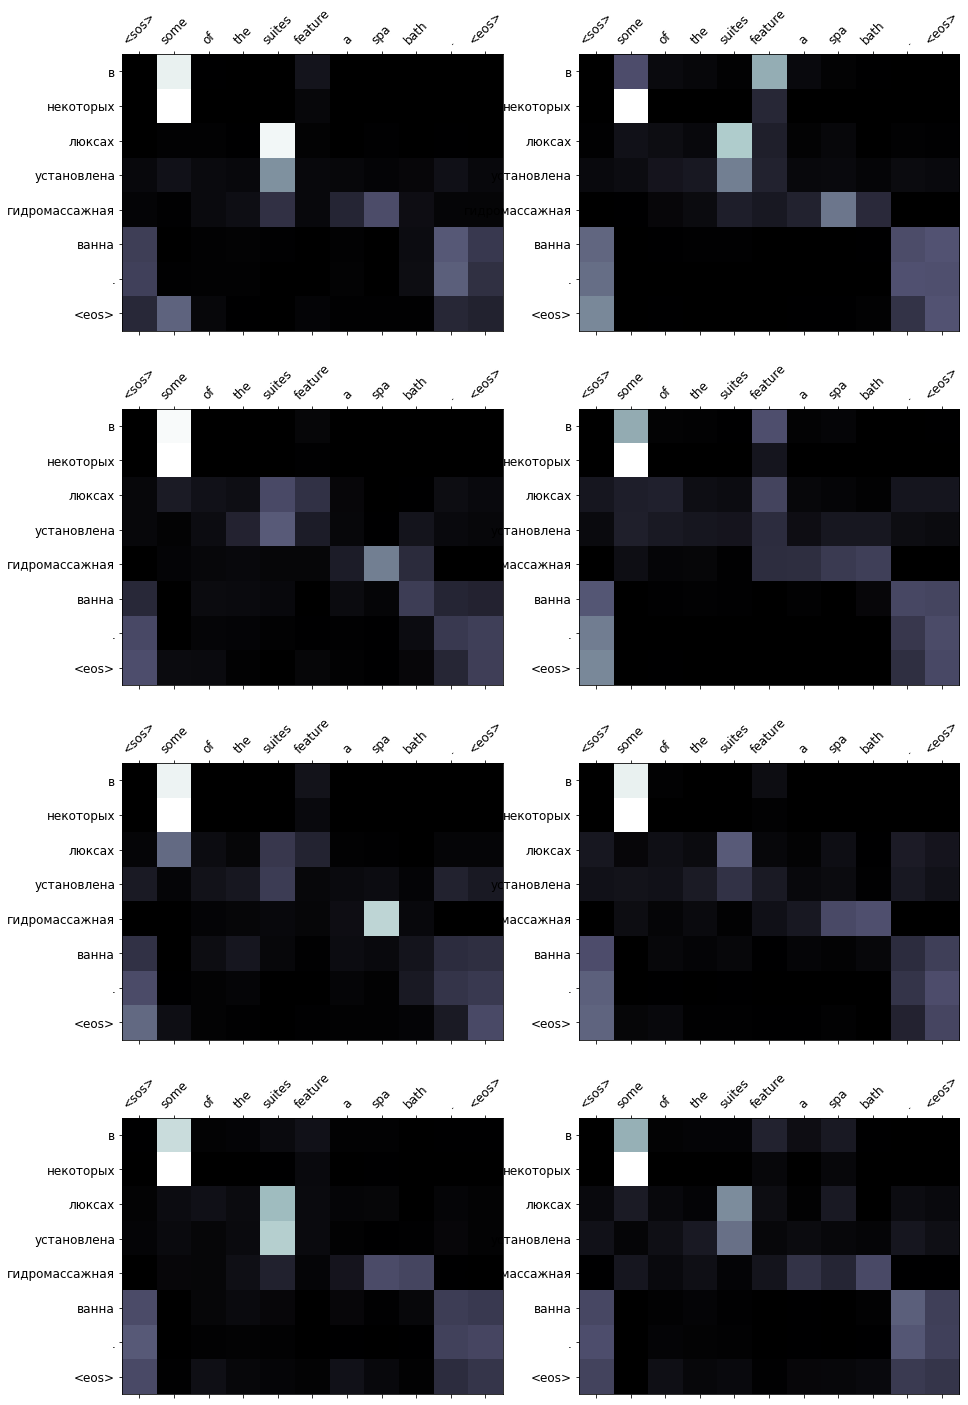

In [38]:
transformer_display_attention(src, translation, attention)

In [39]:
example_idx = 7

src = vars(valid_data.examples[example_idx])['src']
trg = vars(valid_data.examples[example_idx])['trg']

print(f'src = {" ".join(src)}')
print(f'trg = {" ".join(trg)}')

src = breakfast is available as well .
trg = для гостей сервируется завтрак .


predicted trg = завтрак подается завтрак . <eos>


<ipython-input-35-8546ab0d7ba0>:16: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['']+['<sos>']+[t.lower() for t in sentence]+['<eos>'],
<ipython-input-35-8546ab0d7ba0>:18: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['']+translation)


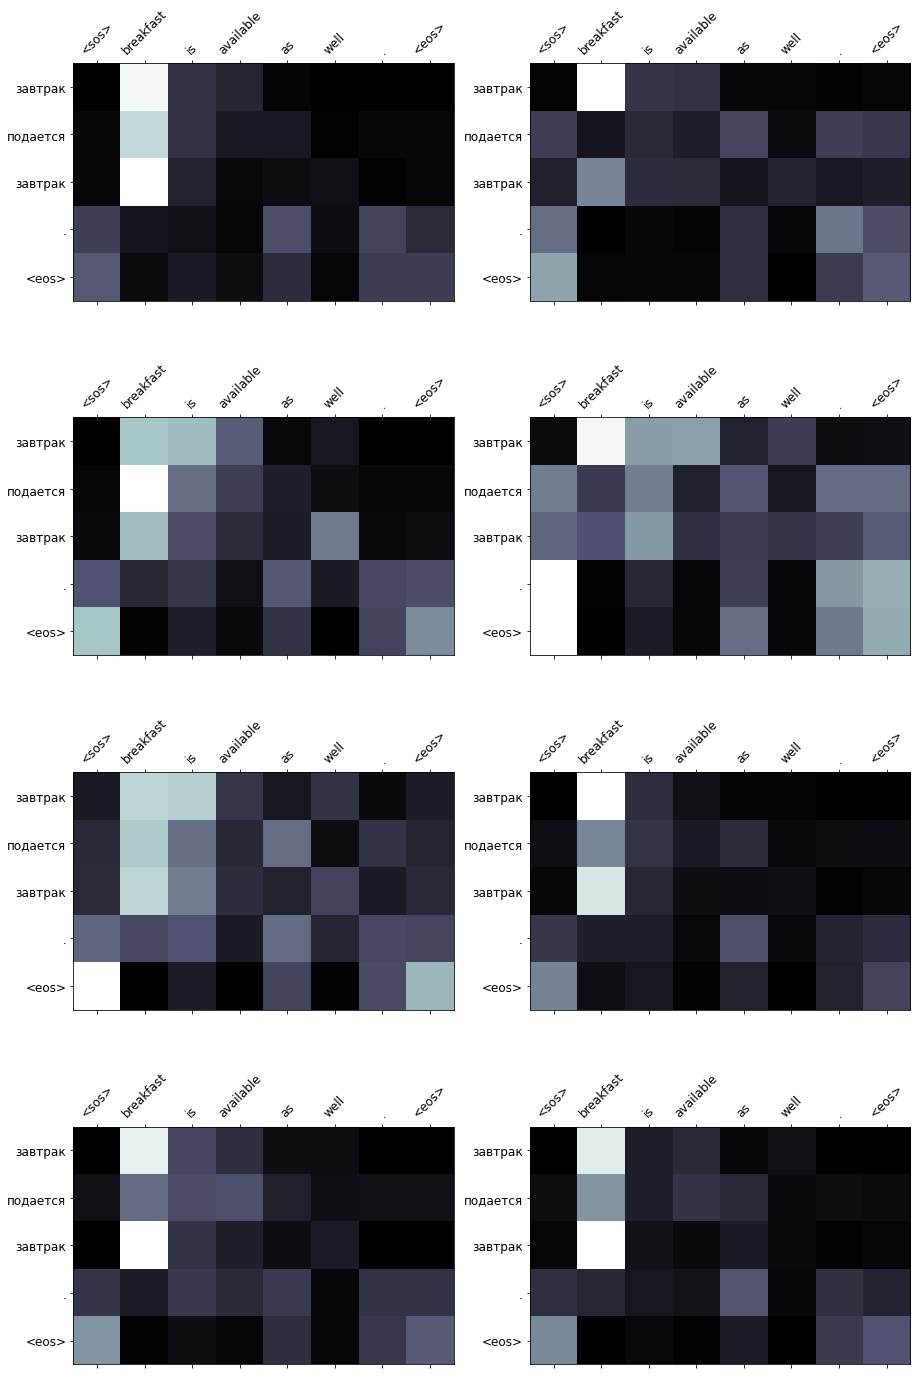

In [40]:
translation, attention = transformer_translate_sentence(src, SRC, TRG, model, device, max_len=100)

print(f'predicted trg = {" ".join(translation)}')

transformer_display_attention(src, translation, attention)

<ipython-input-35-8546ab0d7ba0>:16: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['']+['<sos>']+[t.lower() for t in sentence]+['<eos>'],
<ipython-input-35-8546ab0d7ba0>:18: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['']+translation)


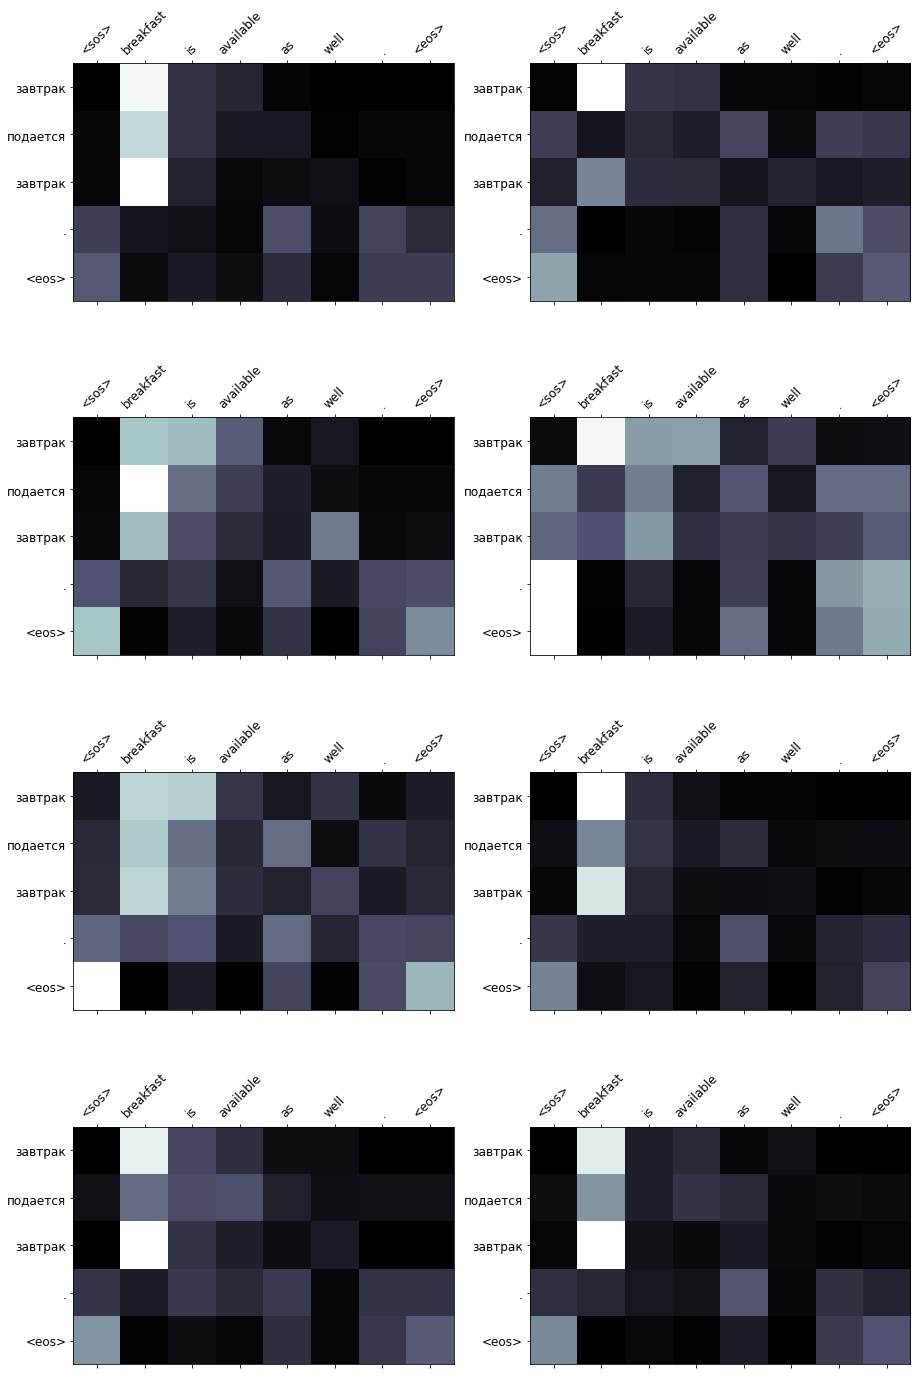

In [41]:
transformer_display_attention(src, translation, attention)

In [42]:
example_idx = 21

src = vars(test_data.examples[example_idx])['src']
trg = vars(test_data.examples[example_idx])['trg']

print(f'src = {" ".join(src)}')
print(f'trg = {" ".join(trg)}')

src = it offers a sun terrace with an outdoor pool and a poolside bar .
trg = к услугам гостей солнечная терраса с открытым бассейном и баром у бассейна .


predicted trg = к услугам гостей солнечная терраса с открытым бассейном и бар у бассейна . <eos>


<ipython-input-35-8546ab0d7ba0>:16: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['']+['<sos>']+[t.lower() for t in sentence]+['<eos>'],
<ipython-input-35-8546ab0d7ba0>:18: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['']+translation)


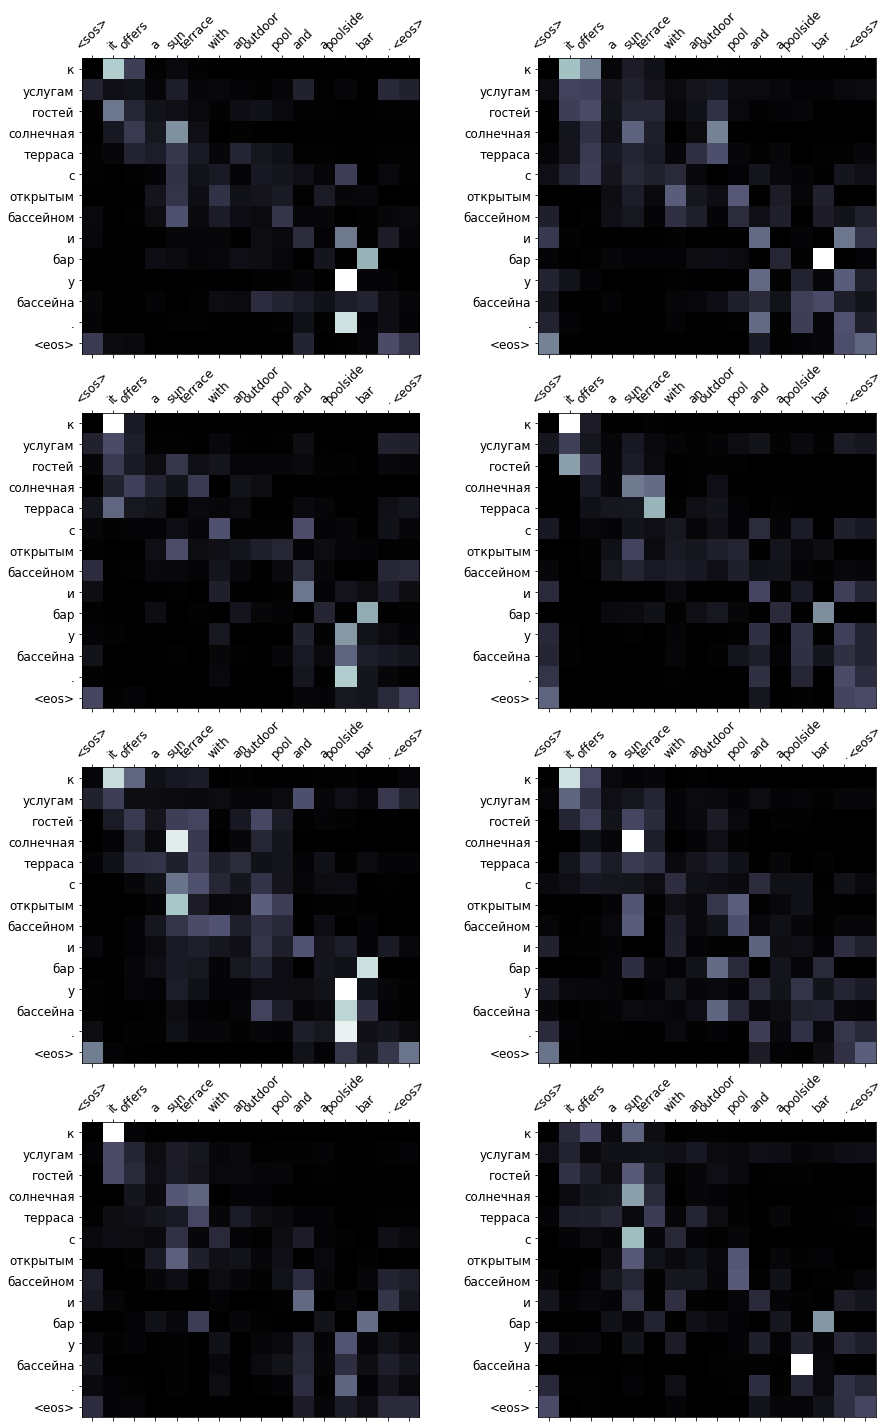

In [43]:
translation, attention = transformer_translate_sentence(src, SRC, TRG, model, device, max_len=100)

print(f'predicted trg = {" ".join(translation)}')

transformer_display_attention(src, translation, attention)

<ipython-input-30-8546ab0d7ba0>:16: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['']+['<sos>']+[t.lower() for t in sentence]+['<eos>'],
<ipython-input-30-8546ab0d7ba0>:18: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['']+translation)


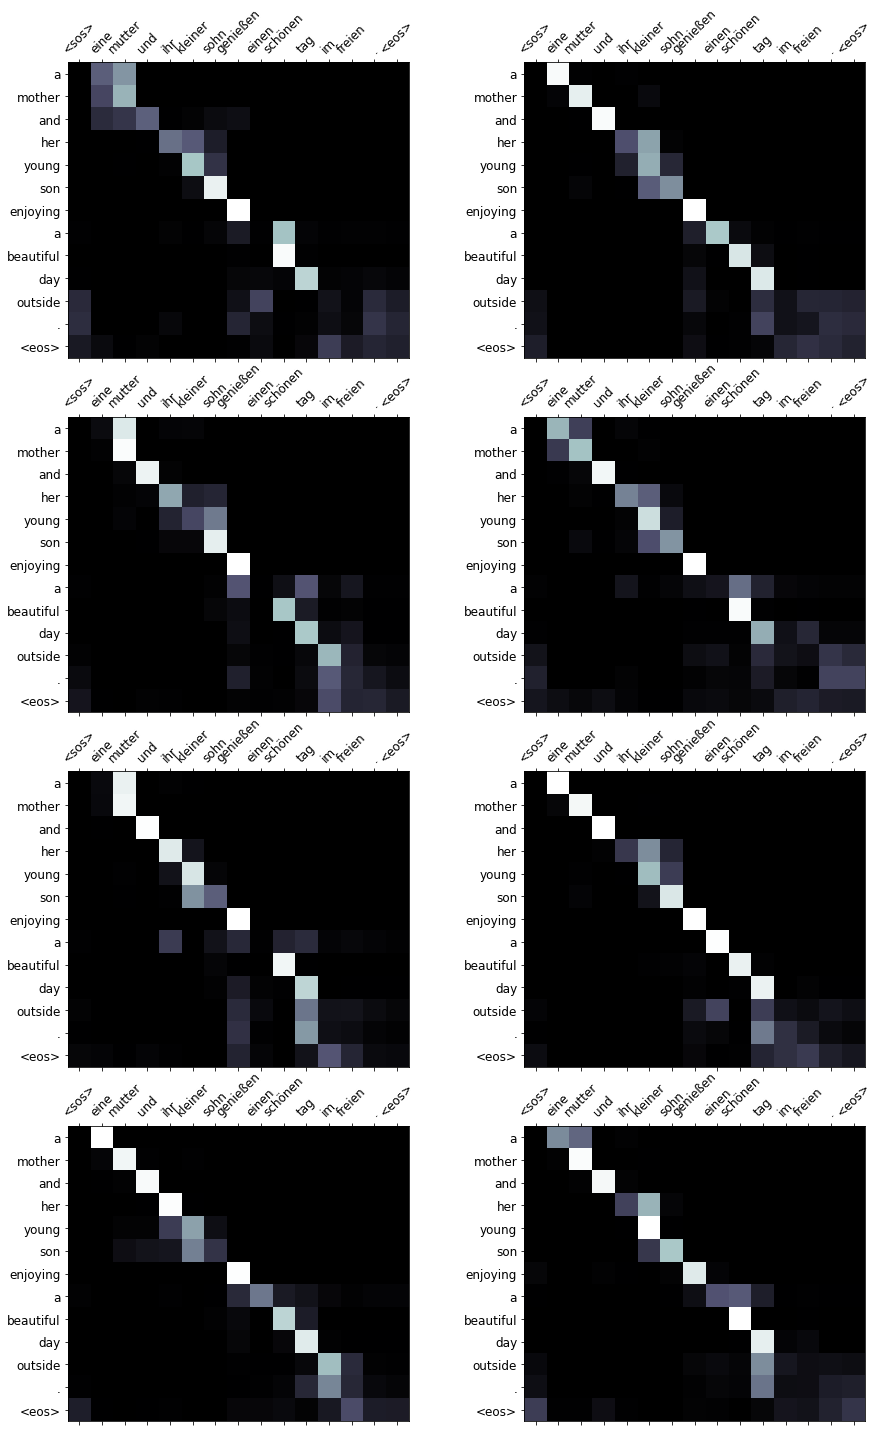

In [ ]:
transformer_display_attention(src, translation, attention)

In [67]:
# from my_utils import calculate_bleu
def calculate_bleu(data, src_field, trg_field, model, device, func=transformer_translate_sentence, max_len = 50):
    trgs = []
    pred_trgs = []
    
    for datum in tqdm(data):
        
        src = vars(datum)['src']
        trg = vars(datum)['trg']
        
        pred_trg, _, _ = func(src, src_field, trg_field, model, device, max_len)
        
        #cut off <eos> token
        pred_trg = pred_trg[:-1]
        
        pred_trgs.append(pred_trg)
        trgs.append([trg])
        
    return bleu_score(pred_trgs, trgs)

In [68]:
bleu_score = calculate_bleu(test_data, SRC, TRG, model, device, func=transformer_translate_sentence, max_len=100)

print(f'BLEU score = {bleu_score*100:.2f}')

  0%|          | 0/7500 [00:00<?, ?it/s]

BLEU score = 0.00
